In [1]:
%load_ext autoreload
%autoreload 2

from pandas import read_excel
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import timeit

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem,DataStructs,Draw,PandasTools,Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger

from IPython.display import Image

# Configure the logging - RDKit is rather verbose..
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
# Set the molecule representation to be SVG 
PandasTools.molRepresentation='svg'
# Loading and standardization method for SMILES -> RDKit molecule object
uncharger = rdMolStandardize.Uncharger()


# Loading and standardization method for SMILES -> RDKit molecule object
uncharger = rdMolStandardize.Uncharger()

import functions as fun

In [2]:
# Loading data sets
specs = pd.read_csv('/home/jovyan/covid-data/SPECS_ready_3.csv')
sss_batchA = pd.read_csv('/home/jovyan/covid-data/COVID_BatchA_ready_3.csv')
specs_version2= pd.read_csv("/home/jovyan/covid-data/specsSarsCov2-v1-CMPDannot.csv")

#Creating final dataset
data = pd.merge(specs[['ID_library', 'SMILES']], sss_batchA[['ID_covid', 'Intensity_MeanIntensity_illumMITO_cells.1','Labels']], 
                left_on= 'ID_library', right_on='ID_covid', how='left')
data = data.drop(['ID_covid'],axis=1)
data.head() 

,ID_library,SMILES,Intensity_MeanIntensity_illumMITO_cells.1,Labels
0,CBK309065,CC1=NN=C2N1C(SC(C)=C3C)=C3C(C4=CC=C(Cl)C=C4)=N...,0.009294,0
1,CBK041145,[H][C@@]12COP([O-])(=O)O[C@@]1([H])[C@@H](O)[C...,0.009393,0
2,CBK200894,CC1CS(=O)(=O)CCN1N=Cc1ccc(o1)[N+]([O-])=O,0.009726,0
3,CBK309015,O=C(N1)SC(CC2=CC=C(OCC(N3C)=NC4=C(C=CC=C4)C3=O...,0.011022,0
4,CBK041791,Fc1ccc(cc1)C(c2ccccc2)(c3ccccc3F)n4ccnc4,0.009869,0


In [3]:
# First we need to parse the SMILES and create RDKit 'molecule' objects 
# the 'standardize' function was the one we defined in the first cell with code in this file
data['MOL'] = data['SMILES'].apply(fun.standardize)
data.head()

### There is a problem with some of the smiles as they return none when trying to convert to molecule. 
### The next step is to fix those cases which may be a product of a typo. 

# Looking for None values
corrupted_smiles_idx_list = data[data['MOL'].isnull()].index.tolist() #finding None values
data[data['MOL'].isnull()].head(5)

,ID_library,SMILES,Intensity_MeanIntensity_illumMITO_cells.1,Labels,MOL
131,CBK309029,O=S(OC1=CC([C@H](O)[C@@H](O)C(NC(C2N(C(C(NC([C...,0.009792,0,None
339,CBK309090,O=C(CC(N)CCCN)NCC(C(N/C(C(NC(C1NC(NCC1)=N)C2=O...,0.009078,0,None
418,CBK309764,CC1=C(CCC(CCCC(C)CCCC(C)CCCC(C)C)(C)O2)C2=C(C)...,0.011273,0,None
447,CBK278005,O=C(C1=C(N)C(C(C)=C2OC3=C(N=C21)C(C(N[C@@H]4C(...,0.009102,0,None
472,CBK309248,C[C@]([C@@](C[C@H]1O)([H])[C@]2(CC[C@@H]3O[C@@...,0.009041,0,None


In [4]:
specs_v2_smiles = specs_version2[['cbkid', 'smiles']] #Bringing second SPECS data set for comparision

for idx in corrupted_smiles_idx_list:
    compound_in_data = data['ID_library'].values[idx]
    idx_in_specsv2 = specs_v2_smiles.loc[specs_v2_smiles['cbkid'] == compound_in_data].index.tolist()[0]
    #compound_in_specsv2 = specs_v2_smiles['cbkid'].values[idx_in_specsv2]
    smiles_in_data = data['SMILES'].values[idx]
    smiles_in_specs_v2 = specs_v2_smiles['smiles'].values[idx_in_specsv2]
    try:
        mol = Chem.MolFromSmiles(smiles_in_specs_v2)
        data['SMILES'] = data['SMILES'].replace(smiles_in_data, smiles_in_specs_v2)
    except 'None here':
        pass
print('Replacements successful')

Replacements successful


### We can go back to reality 

Fragments: 1


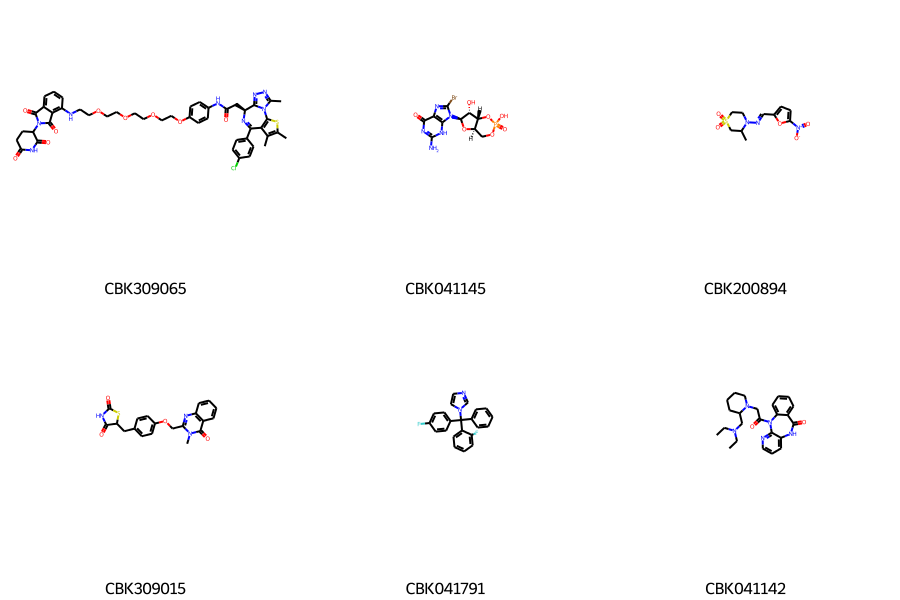

In [5]:
data = data.drop(['MOL'],axis=1)

#Creating molecue objects again
data['MOL'] = data['SMILES'].apply(fun.standardize)
data.head()

# Check if any of the SMILES contain multiple fragments - 
# this can sometimes cause issues when computing descriptors
data['FRAGS'] =  data['MOL'].apply(lambda mol: len(Chem.GetMolFrags(mol,asMols=True)))
print("Fragments: {0}".format(data['FRAGS'].nunique()))

# Compute the descriptors that we're interested in
data['LOGP'] = data['MOL'].apply(lambda mol: Descriptors.MolLogP(mol))
data['HAC'] = data['MOL'].apply(lambda mol: Descriptors.HeavyAtomCount(mol))

# Plot
#plt.figure(figsize=(8,6))
#data.plot.scatter(x='LOGP', y='HAC')
#plt.show()
PandasTools.FrameToGridImage(data[0:6], column='MOL', legendsCol='ID_library', molsPerRow=3, subImgSize=(300, 300))

In [6]:
# Parameters
morgan_radius = 2
morgan_n_bits = 1024
fp_n_bits = 2048
N_QUERIES = 3

# Feature creation
X_morgan, X_rdkit, y = fun.feature_creation(morgan_radius, morgan_n_bits, fp_n_bits, data)

# split dataset into train(5 %), test(25 %), unlabel(70 %)
x_train, y_train, x_test, y_test, x_pool, y_pool = fun.split(x_dataset = X_morgan, y_dataset = y, ini_train_size = 0.3, test_size = 0.3)

# Specify our core estimator along with it's active learning model.
n_neighbours = 3
knn = KNeighborsClassifier(n_neighbors = n_neighbours)
learner = ActiveLearner(estimator=knn, X_training = x_train, y_training = y_train)

# Isolate the data we'll need for plotting.
predictions = learner.predict(x_test) #test the learner in the complete dataset
is_correct = (predictions == y_test) #check its performance

# Record our learner's score on the raw data.
unqueried_score = learner.score(x_test, y_test)
print(f' Score without AL: {unqueried_score}')

 Score without AL: 0.9903038138332256


### Now we introduce AL

In [7]:
#Timer
tic=timeit.default_timer()

# Parameters
N_QUERIES = 800

#Train
prfmc_his, cf_mat_his= fun.active_learnig_train(n_queries = N_QUERIES, x_train = x_train, y_train = y_train, 
                                               x_test = x_test, y_test = y_test, x_pool = x_pool, 
                                               y_pool = y_pool, Classifier = knn)

Accuracy after query 1: 0.9903
Accuracy after query 31: 0.9903
Accuracy after query 61: 0.9903
Accuracy after query 91: 0.9903
Accuracy after query 121: 0.9903
Accuracy after query 151: 0.9903
Accuracy after query 181: 0.9903
Accuracy after query 211: 0.9903
Accuracy after query 241: 0.9903
Accuracy after query 271: 0.9903
Accuracy after query 301: 0.9903
Accuracy after query 331: 0.9903
Accuracy after query 361: 0.9903
Accuracy after query 391: 0.9903
Accuracy after query 421: 0.9903
Accuracy after query 451: 0.9903
Accuracy after query 481: 0.9903
Accuracy after query 511: 0.9903
Accuracy after query 541: 0.9903
Accuracy after query 571: 0.9903
Accuracy after query 601: 0.9903
Accuracy after query 631: 0.9903
Accuracy after query 661: 0.9903
Accuracy after query 691: 0.9903
Accuracy after query 721: 0.9903
Accuracy after query 751: 0.9903
Accuracy after query 781: 0.9903


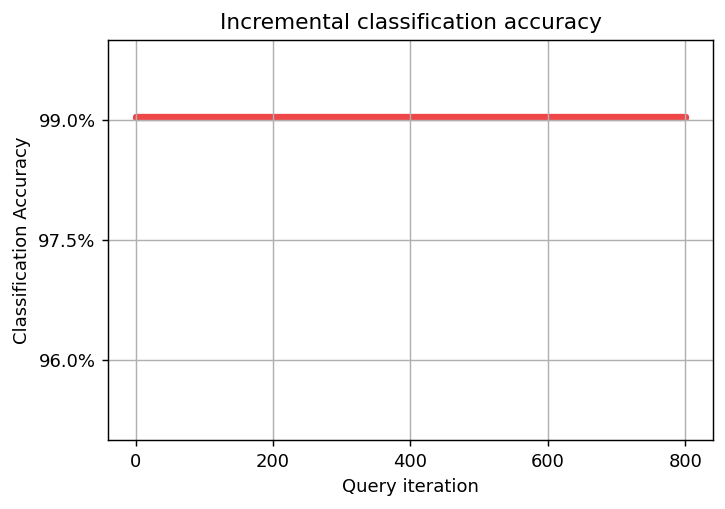

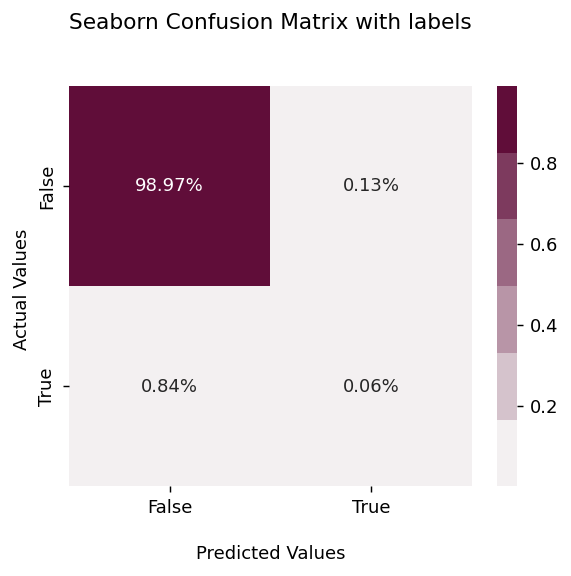



Elapsed time: 1414.073229726404 seconds


In [7]:
#Plot
fun.plot_incremental_accuracy(prfmc_his, save = False, figure_name = 'knn3_0.2_0.25_uncesamp')
fun.plot_cf_mat(matrix = cf_mat_his[-1], save = False , figure_name = None)
plt.show()

toc=timeit.default_timer()
print(f'\n\nElapsed time: {toc-tic} seconds')

In [ ]:
fun.plot_incremental_accuracy(prfmc_his, save = True, figure_name = 'knn3_0.3_0.3_uncesamp')
fun.plot_cf_mat(matrix = cf_mat_his[-1], save = False , figure_name = 'knn3_0.3_0.3_uncesamp')
plt.show()